In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [166]:
Class9 = pd.read_csv('C:/Users/wjssm/Desktop/lpoint/modeling/Class9.csv')
Class9['Date'] = pd.date_range('2018-04-01', '2018-09-30').strftime('%Y-%m-%d')
Class9['Date'] =pd.to_datetime(Class9['Date'])
Class9 = Class9.set_index('Date')
Class9.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,fashion
Date,,,,,
2018-04-01,15446,107.008910,1958.732921,34.931247,383.777778
2018-04-02,13338,91.290241,1738.117266,34.622027,356.888889
2018-04-03,13514,94.545942,1776.986599,34.835746,349.555556
2018-04-04,12405,88.670594,1651.527270,34.530426,339.777778
2018-04-05,11739,90.039054,1731.360890,35.380734,325.111111


In [167]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    diff.append(dataset[0])
    for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
    return pd.Series(diff)

# inverse_difference
def inverse_difference(diff, interval=1):
    origin = list()
    origin.append(diff[0])
    for i in range(interval, len(diff)):
            value = diff[i] + origin[i - interval]
            origin.append(value)
    return pd.Series(origin)

In [168]:
Y = Class9['BUY_CT_sum']

In [169]:
#remove original Y
Class9.drop(columns=['BUY_CT_sum'],inplace=True)
Class9.rename(columns = {'fashion' : 'naver_click'}, inplace=True)
Class9.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2018-04-01,107.008910,1958.732921,34.931247,383.777778
2018-04-02,91.290241,1738.117266,34.622027,356.888889
2018-04-03,94.545942,1776.986599,34.835746,349.555556
2018-04-04,88.670594,1651.527270,34.530426,339.777778
2018-04-05,90.039054,1731.360890,35.380734,325.111111


In [170]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm

#### 변수 조합

In [171]:
#TOT_SESS_HR_V_mean 역수
Class9['TOT_SESS_HR_V_mean'] = 1000/Class9['TOT_SESS_HR_V_mean']
Class9.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2018-04-01,107.008910,0.510534,34.931247,383.777778
2018-04-02,91.290241,0.575335,34.622027,356.888889
2018-04-03,94.545942,0.562750,34.835746,349.555556
2018-04-04,88.670594,0.605500,34.530426,339.777778
2018-04-05,90.039054,0.577580,35.380734,325.111111


#### scaled

In [172]:
scaled_df1=minmax(Class9)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click
Date,,,,
2018-04-01,0.560244,0.146590,0.369025,0.797101
2018-04-02,0.196711,0.553551,0.206432,0.637681
2018-04-03,0.272007,0.474517,0.318809,0.594203
2018-04-04,0.136125,0.742992,0.158267,0.536232
2018-04-05,0.167774,0.567651,0.605372,0.449275


In [173]:
scaled_Y = minmax(Y)

scaled_df1 = pd.concat([scaled_df1, scaled_Y], axis = 1)
scaled_df1.rename(columns={'BUY_CT_sum':'Y'}, inplace=True)

scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,naver_click,Y
Date,,,,,
2018-04-01,0.560244,0.146590,0.369025,0.797101,0.962820
2018-04-02,0.196711,0.553551,0.206432,0.637681,0.785900
2018-04-03,0.272007,0.474517,0.318809,0.594203,0.800671
2018-04-04,0.136125,0.742992,0.158267,0.536232,0.707595
2018-04-05,0.167774,0.567651,0.605372,0.449275,0.651700


#### modeling

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\Users\wjssm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [174]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

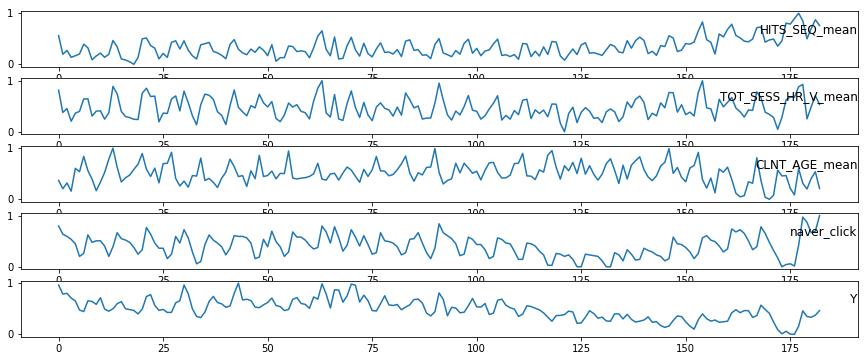

In [79]:
#Plot of all variables
values = scaled_df1.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure(figsize=(15,6))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(scaled_df1.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [80]:
#scaled_data : scaled한 데이터. 사용하려는 변수 + 마지막 칼럼은 Y
#n : 사용하는 변수 개수

scaled_data = scaled_df1
n = 4

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

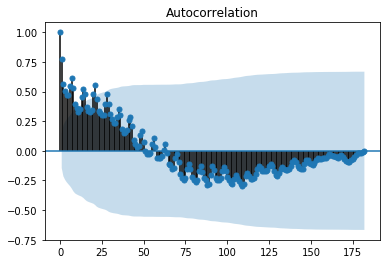

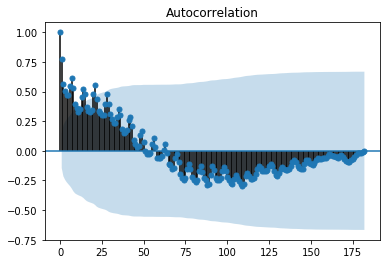

In [81]:
#original data
plot_acf(Y, ax = plt.gca())

In [192]:
scaled_Y = scaled_data['Y']

values = scaled_df1.values
# frame as supervised learning
reframed = series_to_supervised(scaled_df1, 1, 1)
reframed.drop(reframed.columns[-(n+1):-1], axis=1,inplace = True)

# split into train and test sets
values = reframed.values
n_train = int(len(scaled_data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [193]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.15))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=350, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 146 samples, validate on 36 samples
Epoch 1/350
 - 6s - loss: 0.3047 - val_loss: 0.0972
Epoch 2/350
 - 0s - loss: 0.2782 - val_loss: 0.0832
Epoch 3/350
 - 0s - loss: 0.2465 - val_loss: 0.0704
Epoch 4/350
 - 0s - loss: 0.2244 - val_loss: 0.0590
Epoch 5/350
 - 0s - loss: 0.2026 - val_loss: 0.0490
Epoch 6/350
 - 0s - loss: 0.1796 - val_loss: 0.0404
Epoch 7/350
 - 0s - loss: 0.1653 - val_loss: 0.0332
Epoch 8/350
 - 0s - loss: 0.1477 - val_loss: 0.0274
Epoch 9/350
 - 0s - loss: 0.1374 - val_loss: 0.0229
Epoch 10/350
 - 0s - loss: 0.1103 - val_loss: 0.0197
Epoch 11/350
 - 0s - loss: 0.1110 - val_loss: 0.0177
Epoch 12/350
 - 0s - loss: 0.0948 - val_loss: 0.0168
Epoch 13/350
 - 0s - loss: 0.0828 - val_loss: 0.0170
Epoch 14/350
 - 0s - loss: 0.0809 - val_loss: 0.0180
Epoch 15/350
 - 0s - loss: 0.0644 - val_loss: 0.0197
Epoch 16/350
 - 0s - loss: 0.0832 - val_loss: 0.0218
Epoch 17/350
 - 0s - loss: 0.0831 - val_loss: 0.0241
Epoch 18/350
 - 0s - loss: 0.0582 - val_loss: 0.0264
Epoch 19/3

Epoch 154/350
 - 0s - loss: 0.0516 - val_loss: 0.0236
Epoch 155/350
 - 0s - loss: 0.0717 - val_loss: 0.0236
Epoch 156/350
 - 0s - loss: 0.0680 - val_loss: 0.0235
Epoch 157/350
 - 0s - loss: 0.0480 - val_loss: 0.0235
Epoch 158/350
 - 0s - loss: 0.0711 - val_loss: 0.0235
Epoch 159/350
 - 0s - loss: 0.0490 - val_loss: 0.0233
Epoch 160/350
 - 0s - loss: 0.0667 - val_loss: 0.0231
Epoch 161/350
 - 0s - loss: 0.0918 - val_loss: 0.0228
Epoch 162/350
 - 0s - loss: 0.0554 - val_loss: 0.0225
Epoch 163/350
 - 0s - loss: 0.0597 - val_loss: 0.0223
Epoch 164/350
 - 0s - loss: 0.0709 - val_loss: 0.0223
Epoch 165/350
 - 0s - loss: 0.0493 - val_loss: 0.0221
Epoch 166/350
 - 0s - loss: 0.0666 - val_loss: 0.0221
Epoch 167/350
 - 0s - loss: 0.0473 - val_loss: 0.0221
Epoch 168/350
 - 0s - loss: 0.0500 - val_loss: 0.0221
Epoch 169/350
 - 0s - loss: 0.0614 - val_loss: 0.0222
Epoch 170/350
 - 0s - loss: 0.0526 - val_loss: 0.0222
Epoch 171/350
 - 0s - loss: 0.0682 - val_loss: 0.0223
Epoch 172/350
 - 0s - loss: 

Epoch 306/350
 - 0s - loss: 0.0636 - val_loss: 0.0151
Epoch 307/350
 - 0s - loss: 0.0565 - val_loss: 0.0152
Epoch 308/350
 - 0s - loss: 0.0602 - val_loss: 0.0153
Epoch 309/350
 - 0s - loss: 0.0295 - val_loss: 0.0155
Epoch 310/350
 - 0s - loss: 0.0576 - val_loss: 0.0155
Epoch 311/350
 - 0s - loss: 0.0477 - val_loss: 0.0154
Epoch 312/350
 - 0s - loss: 0.0610 - val_loss: 0.0152
Epoch 313/350
 - 0s - loss: 0.0666 - val_loss: 0.0150
Epoch 314/350
 - 0s - loss: 0.0608 - val_loss: 0.0149
Epoch 315/350
 - 0s - loss: 0.0593 - val_loss: 0.0149
Epoch 316/350
 - 0s - loss: 0.0534 - val_loss: 0.0151
Epoch 317/350
 - 0s - loss: 0.0687 - val_loss: 0.0153
Epoch 318/350
 - 0s - loss: 0.0428 - val_loss: 0.0154
Epoch 319/350
 - 0s - loss: 0.0501 - val_loss: 0.0153
Epoch 320/350
 - 0s - loss: 0.0550 - val_loss: 0.0153
Epoch 321/350
 - 0s - loss: 0.0562 - val_loss: 0.0154
Epoch 322/350
 - 0s - loss: 0.0935 - val_loss: 0.0153
Epoch 323/350
 - 0s - loss: 0.0767 - val_loss: 0.0150
Epoch 324/350
 - 0s - loss: 

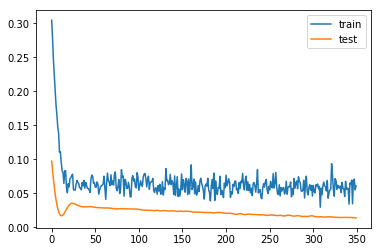

In [195]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [196]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
true_Y = Y.values[n_train+1:].reshape(yhat.shape[0],1)

In [205]:
# invert scaling for forecast
dfhat = np.concatenate((true_Y,yhat), axis = 1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,1],dfhat[:,0])

# calculate RMSE
rmse = np.sqrt(mean_squared_error(true_Y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1549.475


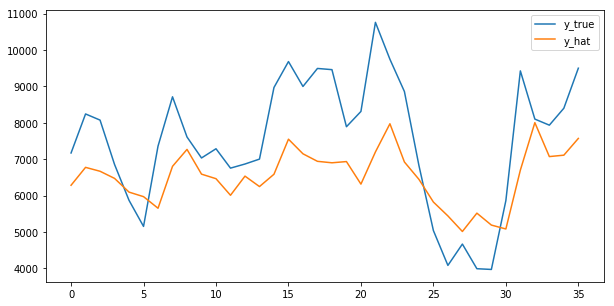

In [206]:
plt.figure(figsize=(10,5))
plt.plot(true_Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat')
plt.legend()

In [199]:
inv_yhat = pd.Series(inv_yhat)
inv_yhat.index = Y[n_train+1:,].index

In [200]:
inv_yhat.index

DatetimeIndex(['2018-08-26', '2018-08-27', '2018-08-28', '2018-08-29',
               '2018-08-30', '2018-08-31', '2018-09-01', '2018-09-02',
               '2018-09-03', '2018-09-04', '2018-09-05', '2018-09-06',
               '2018-09-07', '2018-09-08', '2018-09-09', '2018-09-10',
               '2018-09-11', '2018-09-12', '2018-09-13', '2018-09-14',
               '2018-09-15', '2018-09-16', '2018-09-17', '2018-09-18',
               '2018-09-19', '2018-09-20', '2018-09-21', '2018-09-22',
               '2018-09-23', '2018-09-24', '2018-09-25', '2018-09-26',
               '2018-09-27', '2018-09-28', '2018-09-29', '2018-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

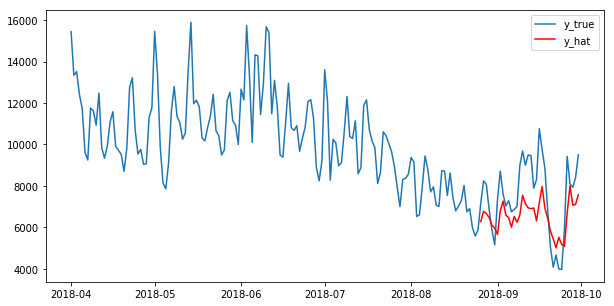

In [203]:
plt.figure(figsize=(10,5))
plt.plot(Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat', c='r')
plt.legend()

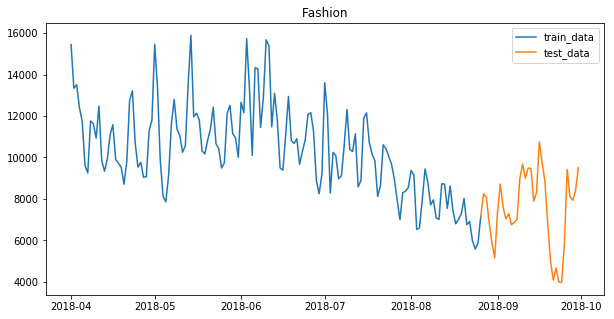

In [202]:
plt.figure(figsize=(10,5))
plt.plot(Y[:n_train+2], label = 'train_data')
plt.plot(Y[n_train+1:], label = 'test_data')
plt.title('Fashion')
plt.legend()